##### Libraries

In [1]:
import numpy as np  # for numerical operations.

import pandas as pd  # for manipulation and analysis.

import seaborn as sns # for visualization.

import matplotlib.pyplot as plt # for visualization.

from sklearn.preprocessing import LabelEncoder # for encoding categorical variables.

from sklearn.preprocessing import StandardScaler # for standardizing numerical variables.

from sklearn.impute import SimpleImputer # for imputing missing values.

from sklearn.pipeline import make_pipeline # for creating pipelines.

from sklearn.linear_model import LogisticRegression # for logistic regression.

from sklearn.model_selection import train_test_split # for splitting data into training and testing sets.

from sklearn.ensemble import RandomForestClassifier # for random forest classifier.

from sklearn.metrics import classification_report, roc_auc_score # for evaluating model performance.

from xgboost import XGBClassifier # for XGBoost classifier.

from sklearn.model_selection import StratifiedKFold, cross_val_score # for cross-validation.

from sklearn.metrics import make_scorer, f1_score # for calculating F1 score.

import lightgbm as lgb # for LightGBM classifier.

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # for confusion matrix.

from sklearn.metrics import precision_recall_curve, average_precision_score # for precision-recall curve.

##### Loading datasets

In [2]:
import kagglehub
import os

# Download the latest version of the dataset
path = kagglehub.dataset_download("rohitrox/healthcare-provider-fraud-detection-analysis")

# Print the dataset path
print("Path to dataset files:", path)

# List files inside the dataset directory
print("\nFiles in the dataset:")
for file in os.listdir(path):
    print("-", file)

Path to dataset files: C:\Users\Administrator\.cache\kagglehub\datasets\rohitrox\healthcare-provider-fraud-detection-analysis\versions\1

Files in the dataset:
- Test-1542969243754.csv
- Test_Beneficiarydata-1542969243754.csv
- Test_Inpatientdata-1542969243754.csv
- Test_Outpatientdata-1542969243754.csv
- Train-1542865627584.csv
- Train_Beneficiarydata-1542865627584.csv
- Train_Inpatientdata-1542865627584.csv
- Train_Outpatientdata-1542865627584.csv


In [3]:
# Set dataset path
dataset_path = r"C:\Users\Administrator\.cache\kagglehub\datasets\rohitrox\healthcare-provider-fraud-detection-analysis\versions\1"

# Load Train Dataset
Train_Provider = pd.read_csv(os.path.join(dataset_path, 'Train-1542865627584.csv'))
Train_Beneficiarydata = pd.read_csv(os.path.join(dataset_path, 'Train_Beneficiarydata-1542865627584.csv'))
Train_Inpatientdata = pd.read_csv(os.path.join(dataset_path, 'Train_Inpatientdata-1542865627584.csv'))
Train_Outpatientdata = pd.read_csv(os.path.join(dataset_path, 'Train_Outpatientdata-1542865627584.csv'))

# Load Test Dataset
Test_Provider = pd.read_csv(os.path.join(dataset_path, 'Test-1542969243754.csv'))
Test_Beneficiarydata = pd.read_csv(os.path.join(dataset_path, 'Test_Beneficiarydata-1542969243754.csv'))
Test_Inpatientdata = pd.read_csv(os.path.join(dataset_path, 'Test_Inpatientdata-1542969243754.csv'))
Test_Outpatientdata = pd.read_csv(os.path.join(dataset_path, 'Test_Outpatientdata-1542969243754.csv'))

##### Shape of the datasets

In [4]:
def print_data_shapes(*dataframes, title="Data Shapes"):
    print("="*40)
    print(title.center(40))
    print("="*40)
    for df_name, df in dataframes:
        print(f"{df_name:<25} : {df.shape}")
    print("="*40)

# Before merging
print_data_shapes(
    ("Train_Provider", Train_Provider),
    ("Train_Beneficiarydata", Train_Beneficiarydata),
    ("Train_Inpatientdata", Train_Inpatientdata),
    ("Train_Outpatientdata", Train_Outpatientdata),
    title="Train Data Shapes"
)

print_data_shapes(
    ("Test_Provider", Test_Provider),
    ("Test_Beneficiarydata", Test_Beneficiarydata),
    ("Test_Inpatientdata", Test_Inpatientdata),
    ("Test_Outpatientdata", Test_Outpatientdata),
    title="Test Data Shapes"
)

           Train Data Shapes            
Train_Provider            : (5410, 2)
Train_Beneficiarydata     : (138556, 25)
Train_Inpatientdata       : (40474, 30)
Train_Outpatientdata      : (517737, 27)
            Test Data Shapes            
Test_Provider             : (1353, 1)
Test_Beneficiarydata      : (63968, 25)
Test_Inpatientdata        : (9551, 30)
Test_Outpatientdata       : (125841, 27)


In [5]:
def merge_and_return_shapes(train_inpatient, test_inpatient,
                            train_outpatient, test_outpatient,
                            train_beneficiary, test_beneficiary,
                            provider_data=None):
    # Merge Inpatient with Beneficiary
    train_inpatient_merged = pd.merge(train_inpatient, train_beneficiary, on='BeneID', how='left')
    test_inpatient_merged = pd.merge(test_inpatient, test_beneficiary, on='BeneID', how='left')
    
    # Merge Outpatient with Beneficiary
    train_outpatient_merged = pd.merge(train_outpatient, train_beneficiary, on='BeneID', how='left')
    test_outpatient_merged = pd.merge(test_outpatient, test_beneficiary, on='BeneID', how='left')
    
    # Combine Inpatient and Outpatient for Train and Test separately
    train_combined = pd.concat([train_inpatient_merged, train_outpatient_merged], axis=0, ignore_index=True)
    test_combined = pd.concat([test_inpatient_merged, test_outpatient_merged], axis=0, ignore_index=True)
    
    # Optionally merge with Provider data (only applicable for Train)
    if provider_data is not None:
        train_combined = pd.merge(train_combined, provider_data, on='Provider', how='left')

    # Return the merged datasets
    return train_combined, test_combined


# call the function to merge and get the combined datasets:
train_combined, test_combined = merge_and_return_shapes(
    Train_Inpatientdata, Test_Inpatientdata, 
    Train_Outpatientdata, Test_Outpatientdata,
    Train_Beneficiarydata, Test_Beneficiarydata,
    provider_data=Train_Provider
)

# Print shapes of combined datasets after merging
print_data_shapes(
    ("Train Combined", train_combined),
    ("Test Combined", test_combined),
    title="Combined Data Shapes After Merging"
)

   Combined Data Shapes After Merging   
Train Combined            : (558211, 55)
Test Combined             : (135392, 54)


##### .info()

In [6]:
def missing_values_summary(df):
    import pandas as pd

    total = len(df)

    # summary df
    missing_df = df.isnull().sum().reset_index()
    missing_df.columns = ['Column', 'Missing_Count']
    missing_df['Missing_Percent'] = (missing_df['Missing_Count'] / total * 100).round(2)
    missing_df['Dtype'] = df.dtypes.values
    missing_df['Total'] = total

    # filter only columns with missing values
    missing_df = missing_df[missing_df['Missing_Count'] > 0]

    if missing_df.empty:
        print("✅ No missing values found in the dataset.")
        return

    # sort by dtype and missing percentage
    missing_df = missing_df.sort_values(by=['Dtype', 'Missing_Percent'], ascending=[True, False])

    # group and print
    for dtype, group in missing_df.groupby('Dtype'):
        print("=" * 70)
        print(f"Missing Values Summary for Data Type: {dtype}".center(70))
        print("=" * 70)
        display(group[['Column', 'Missing_Count', 'Missing_Percent', 'Total']].reset_index(drop=True))

In [7]:
# Missing entries for train dataset
missing_values_summary(train_combined)

            Missing Values Summary for Data Type: float64             


,Column,Missing_Count,Missing_Percent,Total
0,ClmProcedureCode_5,558202,100.00,558211
1,ClmProcedureCode_6,558211,100.00,558211
2,ClmProcedureCode_4,558093,99.98,558211
3,ClmProcedureCode_3,557242,99.83,558211
4,ClmProcedureCode_2,552721,99.02,558211
5,ClmProcedureCode_1,534901,95.82,558211
6,DeductibleAmtPaid,899,0.16,558211


             Missing Values Summary for Data Type: object             


,Column,Missing_Count,Missing_Percent,Total
0,DOD,554080,99.26,558211
1,ClmDiagnosisCode_10,553201,99.10,558211
2,AdmissionDt,517737,92.75,558211
3,DischargeDt,517737,92.75,558211
4,DiagnosisGroupCode,517737,92.75,558211
5,ClmDiagnosisCode_9,516396,92.51,558211
6,ClmDiagnosisCode_8,504767,90.43,558211
7,ClmDiagnosisCode_7,492034,88.14,558211
8,ClmDiagnosisCode_6,473819,84.88,558211
9,ClmDiagnosisCode_5,446287,79.95,558211


In [8]:
# Missing entries for test dataset
missing_values_summary(test_combined)

            Missing Values Summary for Data Type: float64             


,Column,Missing_Count,Missing_Percent,Total
0,ClmProcedureCode_5,135390,100.00,135392
1,ClmProcedureCode_6,135392,100.00,135392
2,ClmProcedureCode_4,135363,99.98,135392
3,ClmProcedureCode_3,135167,99.83,135392
4,ClmProcedureCode_2,134129,99.07,135392
5,ClmProcedureCode_1,129925,95.96,135392
6,DeductibleAmtPaid,196,0.14,135392


             Missing Values Summary for Data Type: object             


,Column,Missing_Count,Missing_Percent,Total
0,DOD,134352,99.23,135392
1,ClmDiagnosisCode_10,134242,99.15,135392
2,AdmissionDt,125841,92.95,135392
3,DischargeDt,125841,92.95,135392
4,DiagnosisGroupCode,125841,92.95,135392
5,ClmDiagnosisCode_9,125516,92.71,135392
6,ClmDiagnosisCode_8,122670,90.60,135392
7,ClmDiagnosisCode_7,119607,88.34,135392
8,ClmDiagnosisCode_6,115232,85.11,135392
9,ClmDiagnosisCode_5,108594,80.21,135392


##### Dropping all columns with .90 threshold.

In [9]:
import pandas as pd

def clean_high_missing_columns(df, threshold=90):
    RED = '\033[91m'
    YELLOW = '\033[93m'
    GREEN = '\033[92m'
    RESET = '\033[0m'

    total = len(df)
    missing_df = df.isnull().sum().reset_index()
    missing_df.columns = ['Column', 'Missing_Count']
    missing_df['Missing_Percent'] = (missing_df['Missing_Count'] / total * 100).round(2)
    missing_df['Dtype'] = df.dtypes.values
    missing_df['Total'] = total

    # Columns to drop
    to_drop = missing_df[missing_df['Missing_Percent'] >= threshold]

    if not to_drop.empty:
        print("=" * 70)
        print(f"{RED}[!] Dropping columns with ≥ {threshold}% missing values".center(70) + RESET)
        print("=" * 70)
        display(to_drop[['Column', 'Missing_Count', 'Missing_Percent', 'Total']])
        df = df.drop(columns=to_drop['Column'].values)
    else:
        print(f"{GREEN}[✓] No columns with ≥ {threshold}% missing values found.{RESET}")

    # Drop rows where 'DeductibleAmtPaid' is missing
    if 'DeductibleAmtPaid' in df.columns:
        missing_rows = df[df['DeductibleAmtPaid'].isnull()]
        if not missing_rows.empty:
            print(f"{RED}[!] Dropping {len(missing_rows)} rows where 'DeductibleAmtPaid' is missing{RESET}")
            df = df.dropna(subset=['DeductibleAmtPaid'])

    # Replace missing values in diagnosis code columns with 'Not Assigned'
    diagnosis_columns = [col for col in df.columns if 'ClmDiagnosisCode' in col or col == 'ClmAdmitDiagnosisCode']
    for column in diagnosis_columns:
        if column in df.columns:
            missing_count = df[column].isnull().sum()
            if missing_count > 0:
                print(f"{YELLOW}[~] Filling {missing_count} missing values in '{column}' with 'Not Assigned'{RESET}")
                df[column] = df[column].fillna('Not Assigned')

    # Replace missing values in physician columns with 'Not Assigned'
    physician_columns = ['OperatingPhysician', 'AttendingPhysician', 'OtherPhysician']
    for column in physician_columns:
        if column in df.columns:
            missing_count = df[column].isnull().sum()
            if missing_count > 0:
                print(f"{YELLOW}[~] Filling {missing_count} missing values in '{column}' with 'Not Assigned'{RESET}")
                df[column] = df[column].fillna('Not Assigned')

    return df

In [10]:
# clean up missing values, threshold 0.9
train_combined = clean_high_missing_columns(train_combined)

         [!] Dropping columns with ≥ 90% missing values          


,Column,Missing_Count,Missing_Percent,Total
9,AdmissionDt,517737,92.75,558211
12,DischargeDt,517737,92.75,558211
13,DiagnosisGroupCode,517737,92.75,558211
21,ClmDiagnosisCode_8,504767,90.43,558211
22,ClmDiagnosisCode_9,516396,92.51,558211
23,ClmDiagnosisCode_10,553201,99.10,558211
24,ClmProcedureCode_1,534901,95.82,558211
25,ClmProcedureCode_2,552721,99.02,558211
26,ClmProcedureCode_3,557242,99.83,558211
27,ClmProcedureCode_4,558093,99.98,558211


[!] Dropping 899 rows where 'DeductibleAmtPaid' is missing
[~] Filling 412312 missing values in 'ClmAdmitDiagnosisCode' with 'Not Assigned'
[~] Filling 10453 missing values in 'ClmDiagnosisCode_1' with 'Not Assigned'
[~] Filling 195601 missing values in 'ClmDiagnosisCode_2' with 'Not Assigned'
[~] Filling 315143 missing values in 'ClmDiagnosisCode_3' with 'Not Assigned'
[~] Filling 393650 missing values in 'ClmDiagnosisCode_4' with 'Not Assigned'
[~] Filling 446238 missing values in 'ClmDiagnosisCode_5' with 'Not Assigned'
[~] Filling 473744 missing values in 'ClmDiagnosisCode_6' with 'Not Assigned'
[~] Filling 491921 missing values in 'ClmDiagnosisCode_7' with 'Not Assigned'
[~] Filling 443409 missing values in 'OperatingPhysician' with 'Not Assigned'
[~] Filling 1499 missing values in 'AttendingPhysician' with 'Not Assigned'
[~] Filling 357674 missing values in 'OtherPhysician' with 'Not Assigned'


In [11]:
# clean up missing values, threshold 0.9
test_combined = clean_high_missing_columns(test_combined)

         [!] Dropping columns with ≥ 90% missing values          


,Column,Missing_Count,Missing_Percent,Total
9,AdmissionDt,125841,92.95,135392
12,DischargeDt,125841,92.95,135392
13,DiagnosisGroupCode,125841,92.95,135392
21,ClmDiagnosisCode_8,122670,90.60,135392
22,ClmDiagnosisCode_9,125516,92.71,135392
23,ClmDiagnosisCode_10,134242,99.15,135392
24,ClmProcedureCode_1,129925,95.96,135392
25,ClmProcedureCode_2,134129,99.07,135392
26,ClmProcedureCode_3,135167,99.83,135392
27,ClmProcedureCode_4,135363,99.98,135392


[!] Dropping 196 rows where 'DeductibleAmtPaid' is missing
[~] Filling 100036 missing values in 'ClmAdmitDiagnosisCode' with 'Not Assigned'
[~] Filling 2578 missing values in 'ClmDiagnosisCode_1' with 'Not Assigned'
[~] Filling 47783 missing values in 'ClmDiagnosisCode_2' with 'Not Assigned'
[~] Filling 76740 missing values in 'ClmDiagnosisCode_3' with 'Not Assigned'
[~] Filling 95770 missing values in 'ClmDiagnosisCode_4' with 'Not Assigned'
[~] Filling 108586 missing values in 'ClmDiagnosisCode_5' with 'Not Assigned'
[~] Filling 115217 missing values in 'ClmDiagnosisCode_6' with 'Not Assigned'
[~] Filling 119585 missing values in 'ClmDiagnosisCode_7' with 'Not Assigned'
[~] Filling 108132 missing values in 'OperatingPhysician' with 'Not Assigned'
[~] Filling 345 missing values in 'AttendingPhysician' with 'Not Assigned'
[~] Filling 86587 missing values in 'OtherPhysician' with 'Not Assigned'


In [12]:
# Missing entries for train dataset, after clean_up
missing_values_summary(train_combined)

✅ No missing values found in the dataset.


In [13]:
# Missing entries for test dataset, after clean_up
missing_values_summary(test_combined)

✅ No missing values found in the dataset.


In [14]:
import pandas as pd

def check_duplicates(train_combined, test_combined):
    print("~" * 70)
    print("🔍 Checking for duplicate rows in each dataset".center(70))
    print("~" * 70)

    # Train dataset
    train_duplicates = train_combined[train_combined.duplicated()]
    if not train_duplicates.empty:
        print(f"[!] Train set has {len(train_duplicates)} duplicate rows.")
    else:
        print("[✓] No duplicates found in train set.")

    # Test dataset
    test_duplicates = test_combined[test_combined.duplicated()]
    if not test_duplicates.empty:
        print(f"[!] Test set has {len(test_duplicates)} duplicate rows.")
    else:
        print("[✓] No duplicates found in test set.")

    return train_duplicates, test_duplicates

In [15]:
# duplicates check
train_duplicates, test_duplicates = check_duplicates(train_combined, test_combined)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            🔍 Checking for duplicate rows in each dataset             
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[✓] No duplicates found in train set.
[✓] No duplicates found in test set.


In [16]:
def convert_date_columns(df, date_columns):
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
            print(f"[✓] Converted '{col}' to datetime")
        else:
            print(f"[!] Column '{col}' not found in DataFrame")
    return df

In [17]:
date_cols = ['ClaimStartDt', 'ClaimEndDt', 'DOB']

# Convert in both datasets
train_combined = convert_date_columns(train_combined, date_cols)
test_combined = convert_date_columns(test_combined, date_cols)

[✓] Converted 'ClaimStartDt' to datetime
[✓] Converted 'ClaimEndDt' to datetime
[✓] Converted 'DOB' to datetime
[✓] Converted 'ClaimStartDt' to datetime
[✓] Converted 'ClaimEndDt' to datetime
[✓] Converted 'DOB' to datetime


In [18]:
def check_date_format(df, date_columns, df_name='Dataset'):
    print(f"\n{'~'*70}")
    print(f"🗓️  Date Format Check in {df_name}")
    print(f"{'~'*70}")
    for col in date_columns:
        if col in df.columns:
            dtype = df[col].dtype
            is_datetime = pd.api.types.is_datetime64_any_dtype(df[col])
            status = "✅ datetime64[ns]" if is_datetime else f"❌ {dtype}"
            print(f"{col:<20} : {status}")
        else:
            print(f"{col:<20} : ⚠️ Column not found")

In [19]:
date_cols = ['ClaimStartDt', 'ClaimEndDt', 'DOB']

check_date_format(train_combined, date_cols, 'Train Dataset')
check_date_format(test_combined, date_cols, 'Test Dataset')


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
🗓️  Date Format Check in Train Dataset
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ClaimStartDt         : ✅ datetime64[ns]
ClaimEndDt           : ✅ datetime64[ns]
DOB                  : ✅ datetime64[ns]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
🗓️  Date Format Check in Test Dataset
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ClaimStartDt         : ✅ datetime64[ns]
ClaimEndDt           : ✅ datetime64[ns]
DOB                  : ✅ datetime64[ns]


In [20]:
# Chronic Conditions Count
train_combined['ClaimDuration'] = (pd.to_datetime(train_combined['ClaimEndDt']) - pd.to_datetime(train_combined['ClaimStartDt'])).dt.days
test_combined['ClaimDuration'] = (pd.to_datetime(test_combined['ClaimEndDt']) - pd.to_datetime(test_combined['ClaimStartDt'])).dt.days

In [21]:
# latest claim date as the reference date
latest_claim_date = pd.to_datetime(train_combined['ClaimEndDt']).max()

# Calculate age based on the latest claim date (or any other suitable date)
train_combined['Age'] = (latest_claim_date - pd.to_datetime(train_combined['DOB'])).dt.days // 365
test_combined['Age'] = (latest_claim_date - pd.to_datetime(test_combined['DOB'])).dt.days // 365

In [22]:
chronic_conditions_columns = [
    'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
    'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
    'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
    'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke'
]
train_combined['TotalChronicConditions'] = train_combined[chronic_conditions_columns].sum(axis=1)
test_combined['TotalChronicConditions'] = test_combined[chronic_conditions_columns].sum(axis=1)

In [23]:
# Reimbursement vs Deductible Ratio
train_combined['ReimbursementDeductibleRatio'] = train_combined['InscClaimAmtReimbursed'] / train_combined['DeductibleAmtPaid']
test_combined['ReimbursementDeductibleRatio'] = test_combined['InscClaimAmtReimbursed'] / test_combined['DeductibleAmtPaid']

In [24]:
# claim types
train_combined['ClaimType'] = train_combined[['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3']].apply(lambda x: '-'.join(x.dropna().astype(str)), axis=1)
test_combined['ClaimType'] = test_combined[['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3']].apply(lambda x: '-'.join(x.dropna().astype(str)), axis=1)

In [25]:
# fraud indicator
train_combined['IsFraud'] = train_combined['PotentialFraud'].apply(lambda x: 1 if x == 'Y' else 0)

In [26]:
# provider claim count
train_combined['ProviderClaimCount'] = train_combined.groupby('Provider')['ClaimID'].transform('count')
test_combined['ProviderClaimCount'] = test_combined.groupby('Provider')['ClaimID'].transform('count')

In [27]:
# Reimbursement Amount per Chronic Condition
train_combined['ReimbursementPerCondition'] = train_combined['InscClaimAmtReimbursed'] / (train_combined['TotalChronicConditions'] + 1)
test_combined['ReimbursementPerCondition'] = test_combined['InscClaimAmtReimbursed'] / (test_combined['TotalChronicConditions'] + 1)

In [28]:
# saving files to csv
train_combined.to_csv('train_combined.csv', index=False)
test_combined.to_csv('test_combined.csv', index=False)

##### Encoding

In [33]:
cols = ['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'Provider']

for col in cols:
    print(f"\nColumn: {col}")
    print(f"Unique values count: {Train_Combined[col].nunique()}")
    print(f"Top 5 most frequent values:\n{Train_Combined[col].value_counts().head()}")
    print(f"Number of missing/unknown: {(Train_Combined[col] == 'Unknown').sum() + (Train_Combined[col] == 'Missing').sum()}")


Column: AttendingPhysician
Unique values count: 82063
Top 5 most frequent values:
AttendingPhysician
PHY330576    3930
PHY350277    1628
PHY412132    1321
PHY423534    1223
PHY314027    1200
Name: count, dtype: int64
Number of missing/unknown: 0

Column: OperatingPhysician
Unique values count: 35316
Top 5 most frequent values:
OperatingPhysician
Unknown      443764
PHY330576       424
PHY424897       293
PHY314027       256
PHY423534       250
Name: count, dtype: int64
Number of missing/unknown: 443764

Column: OtherPhysician
Unique values count: 46458
Top 5 most frequent values:
OtherPhysician
Unknown      358475
PHY412132      1247
PHY341578      1098
PHY338032      1070
PHY337425      1041
Name: count, dtype: int64
Number of missing/unknown: 358475

Column: Provider
Unique values count: 5410
Top 5 most frequent values:
Provider
PRV51459    8240
PRV53797    4739
PRV51574    4444
PRV53918    3588
PRV54895    3436
Name: count, dtype: int64
Number of missing/unknown: 0


In [34]:
print(f"{col} Unique Values - Train: {Train_Combined[col].nunique()}, Test: {Test_Combined[col].nunique()}")

Provider Unique Values - Train: 5410, Test: 1353


In [35]:
# Label Encoding

label_cols = ['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'Provider']

for col in label_cols:
    le = LabelEncoder()
    
    # Combine Train & Test column values to fit encoder
    combined_vals = pd.concat([Train_Combined[col], Test_Combined[col]]).astype(str)
    le.fit(combined_vals)
    
    # Transform both datasets
    Train_Combined[col] = le.transform(Train_Combined[col].astype(str))
    Test_Combined[col] = le.transform(Test_Combined[col].astype(str))

print("Label Encoding completed successfully!")

Label Encoding completed successfully!


In [36]:
print(Train_Combined.columns.tolist())

['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider', 'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode', 'DischargeDt', 'DiagnosisGroupCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmProcedureCode_1', 'ClmProcedureCode_2', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'De

In [37]:
print(Test_Combined.columns.tolist())

['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider', 'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode', 'DischargeDt', 'DiagnosisGroupCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmProcedureCode_1', 'ClmProcedureCode_2', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'De

In [38]:
categorical_cols = ['Gender', 'Race', 'RenalDiseaseIndicator', 'PotentialFraud']

# For Train Data
cols_to_encode_train = [col for col in categorical_cols if col in Train_Combined.columns]
Train_Combined = pd.get_dummies(Train_Combined, columns=cols_to_encode_train, drop_first=True)

# For Test Data
cols_to_encode_test = [col for col in categorical_cols if col in Test_Combined.columns]
Test_Combined = pd.get_dummies(Test_Combined, columns=cols_to_encode_test, drop_first=True)

# Align columns
Train_Combined, Test_Combined = Train_Combined.align(Test_Combined, join='left', axis=1, fill_value=0)

In [39]:
label_cols_remaining = ['State', 'County', 'DiagnosisGroupCode', 'ClmAdmitDiagnosisCode',
                        'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
                        'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
                        'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
                        'ClmProcedureCode_1', 'ClmProcedureCode_2']

for col in label_cols_remaining:
    le = LabelEncoder()
    
    # Combine Train & Test values for consistency
    combined_vals = pd.concat([Train_Combined[col], Test_Combined[col]]).astype(str)
    le.fit(combined_vals)
    
    # Transform both datasets
    Train_Combined[col] = le.transform(Train_Combined[col].astype(str))
    Test_Combined[col] = le.transform(Test_Combined[col].astype(str))

print("Remaining Label Encoding completed successfully!")

Remaining Label Encoding completed successfully!


In [40]:
# Claim duration
Train_Combined['ClaimStartDt'] = pd.to_datetime(Train_Combined['ClaimStartDt'])
Train_Combined['ClaimEndDt'] = pd.to_datetime(Train_Combined['ClaimEndDt'])
Test_Combined['ClaimStartDt'] = pd.to_datetime(Test_Combined['ClaimStartDt'])
Test_Combined['ClaimEndDt'] = pd.to_datetime(Test_Combined['ClaimEndDt'])

Train_Combined['Claim_Duration'] = (Train_Combined['ClaimEndDt'] - Train_Combined['ClaimStartDt']).dt.days
Test_Combined['Claim_Duration'] = (Test_Combined['ClaimEndDt'] - Test_Combined['ClaimStartDt']).dt.days

In [41]:
# Length of Stay
Train_Combined['AdmissionDt'] = pd.to_datetime(Train_Combined['AdmissionDt'], errors='coerce')
Train_Combined['DischargeDt'] = pd.to_datetime(Train_Combined['DischargeDt'], errors='coerce')
Test_Combined['AdmissionDt'] = pd.to_datetime(Test_Combined['AdmissionDt'], errors='coerce')
Test_Combined['DischargeDt'] = pd.to_datetime(Test_Combined['DischargeDt'], errors='coerce')

Train_Combined['Length_of_Stay'] = (Train_Combined['DischargeDt'] - Train_Combined['AdmissionDt']).dt.days
Test_Combined['Length_of_Stay'] = (Test_Combined['DischargeDt'] - Test_Combined['AdmissionDt']).dt.days

In [42]:
# Age
Train_Combined['DOB'] = pd.to_datetime(Train_Combined['DOB'], errors='coerce')
Test_Combined['DOB'] = pd.to_datetime(Test_Combined['DOB'], errors='coerce')

Train_Combined['Age'] = Train_Combined['ClaimStartDt'].dt.year - Train_Combined['DOB'].dt.year
Test_Combined['Age'] = Test_Combined['ClaimStartDt'].dt.year - Test_Combined['DOB'].dt.year

In [43]:
# Deceased Flag
Train_Combined['DOD'] = pd.to_datetime(Train_Combined['DOD'], errors='coerce')
Test_Combined['DOD'] = pd.to_datetime(Test_Combined['DOD'], errors='coerce')

Train_Combined['Deceased_Flag'] = (Train_Combined['DOD'].notnull()) & (Train_Combined['ClaimStartDt'] > Train_Combined['DOD'])
Train_Combined['Deceased_Flag'] = Train_Combined['Deceased_Flag'].astype(int)

Test_Combined['Deceased_Flag'] = (Test_Combined['DOD'].notnull()) & (Test_Combined['ClaimStartDt'] > Test_Combined['DOD'])
Test_Combined['Deceased_Flag'] = Test_Combined['Deceased_Flag'].astype(int)

In [44]:
# Claim and Month/Year
Train_Combined['Claim_Month'] = Train_Combined['ClaimStartDt'].dt.month
Train_Combined['Claim_Year'] = Train_Combined['ClaimStartDt'].dt.year

Test_Combined['Claim_Month'] = Test_Combined['ClaimStartDt'].dt.month
Test_Combined['Claim_Year'] = Test_Combined['ClaimStartDt'].dt.year

In [45]:
# Number of Diagnoses & Procedures per Claim
Train_Combined['Num_Diagnoses'] = Train_Combined[[f'ClmDiagnosisCode_{i}' for i in range(1,10)]].notnull().sum(axis=1)
Test_Combined['Num_Diagnoses'] = Test_Combined[[f'ClmDiagnosisCode_{i}' for i in range(1,10)]].notnull().sum(axis=1)

Train_Combined['Num_Procedures'] = Train_Combined[[f'ClmProcedureCode_{i}' for i in range(1,3)]].notnull().sum(axis=1)
Test_Combined['Num_Procedures'] = Test_Combined[[f'ClmProcedureCode_{i}' for i in range(1,3)]].notnull().sum(axis=1)

In [46]:
# Chronic conditions sum
chronic_cols = [col for col in Train_Combined.columns if 'ChronicCond_' in col]

Train_Combined['Chronic_Cond_Sum'] = Train_Combined[chronic_cols].sum(axis=1)
Test_Combined['Chronic_Cond_Sum'] = Test_Combined[chronic_cols].sum(axis=1)

In [47]:
# Average Deductible/Reimbursement Amount per Claim
Train_Combined['Avg_Deductible'] = (Train_Combined['IPAnnualDeductibleAmt'] + Train_Combined['OPAnnualDeductibleAmt']) / 2
Test_Combined['Avg_Deductible'] = (Test_Combined['IPAnnualDeductibleAmt'] + Test_Combined['OPAnnualDeductibleAmt']) / 2

Train_Combined['Avg_Reimbursement'] = (Train_Combined['IPAnnualReimbursementAmt'] + Train_Combined['OPAnnualReimbursementAmt']) / 2
Test_Combined['Avg_Reimbursement'] = (Test_Combined['IPAnnualReimbursementAmt'] + Test_Combined['OPAnnualReimbursementAmt']) / 2

In [48]:
# Unique Beneficiary Count of Claims
beneficiary_claim_count = Train_Combined['BeneID'].value_counts().to_dict()
Train_Combined['Bene_Claim_Count'] = Train_Combined['BeneID'].map(beneficiary_claim_count)
Test_Combined['Bene_Claim_Count'] = Test_Combined['BeneID'].map(lambda x: beneficiary_claim_count.get(x, 0))

In [49]:
# Previous fraud indicator
provider_fraud = Train_Combined.groupby('Provider')['PotentialFraud_Yes'].max()
Train_Combined['Provider_Prev_Fraud'] = Train_Combined['Provider'].map(provider_fraud)
Test_Combined['Provider_Prev_Fraud'] = Test_Combined['Provider'].map(lambda x: provider_fraud.get(x, 0))

In [50]:
# One-hot encoding for claim month
Train_Combined = pd.get_dummies(Train_Combined, columns=['Claim_Month'], prefix='Month', drop_first=True)
Test_Combined = pd.get_dummies(Test_Combined, columns=['Claim_Month'], prefix='Month', drop_first=True)

Train_Combined, Test_Combined = Train_Combined.align(Test_Combined, join='left', axis=1, fill_value=0)

In [51]:
# Dropping the leakage feature
if 'ClaimStartDt' in Train_Combined.columns:
    Train_Combined['Claim_Month'] = Train_Combined['ClaimStartDt'].dt.month
if 'ClaimStartDt' in Test_Combined.columns:
    Test_Combined['Claim_Month'] = Test_Combined['ClaimStartDt'].dt.month

# Columns to drop (dates + identifiers + high-leakage features)
cols_to_drop = [
    'ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt',
    'DOB', 'DOD', 'ClaimID', 'BeneID', 
    'Provider_Prev_Fraud'  # <--- Dropping the leakage feature
]

# Drop from Train & Test if columns exist
Train_Combined.drop(columns=[col for col in cols_to_drop if col in Train_Combined.columns], inplace=True)
Test_Combined.drop(columns=[col for col in cols_to_drop if col in Test_Combined.columns], inplace=True)

print("Date, ID, and leakage columns dropped successfully!")

# Encoding 'Claim_Month' (recommended)
if 'Claim_Month' in Train_Combined.columns:
    Train_Combined = pd.get_dummies(Train_Combined, columns=['Claim_Month'], prefix='Month', drop_first=True)
if 'Claim_Month' in Test_Combined.columns:
    Test_Combined = pd.get_dummies(Test_Combined, columns=['Claim_Month'], prefix='Month', drop_first=True)

# Align columns after encoding
Train_Combined, Test_Combined = Train_Combined.align(Test_Combined, join='left', axis=1, fill_value=0)

print("Claim_Month encoding completed!")

# Save to new CSV files
Train_Combined.to_csv('Train_Cleaned_Encoded.csv', index=False)
Test_Combined.to_csv('Test_Cleaned_Encoded.csv', index=False)

print("New cleaned & encoded files saved successfully!")


Date, ID, and leakage columns dropped successfully!
Claim_Month encoding completed!
New cleaned & encoded files saved successfully!


##### Load encoded cleaned data

In [53]:
train_df = pd.read_csv('Train_Cleaned_Encoded.csv')
test_df = pd.read_csv('Test_Cleaned_Encoded.csv')

# Separate target
y = train_df['PotentialFraud_Yes']  # Assuming binary 0/1
X_train = train_df.drop('PotentialFraud_Yes', axis=1)
X_test = test_df.copy()  # No target column in test set

##### Normalization

In [54]:
# Separate target variable
y = train_df['PotentialFraud_Yes']
X_train = train_df.drop('PotentialFraud_Yes', axis=1)

# Remove 'PotentialFraud_Yes' from test if it exists
if 'PotentialFraud_Yes' in test_df.columns:
    X_test = test_df.drop('PotentialFraud_Yes', axis=1)
else:
    X_test = test_df.copy()

# Normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Normalization successful!")

Normalization successful!


##### Validation

In [55]:
# Split for validation
X_tr, X_val, y_tr, y_val = train_test_split(X_train_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Train Random Forest (as an example)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_tr, y_tr)

# Evaluate
y_pred = rf.predict(X_val)
print(classification_report(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.82      0.94      0.88     69083
        True       0.87      0.67      0.76     42560

    accuracy                           0.84    111643
   macro avg       0.85      0.80      0.82    111643
weighted avg       0.84      0.84      0.83    111643

ROC AUC Score: 0.8038190223792585


##### Feature Importance

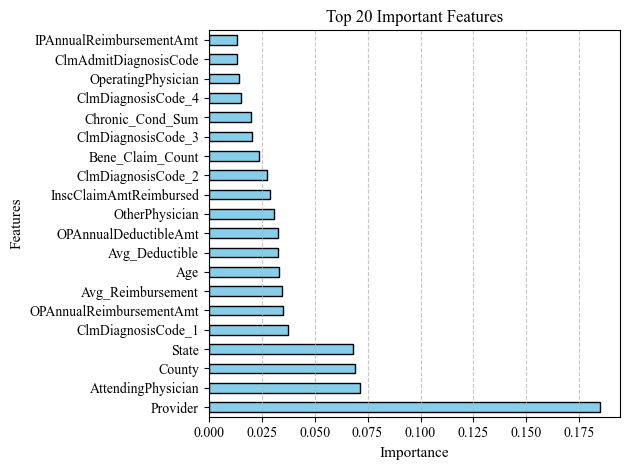

In [56]:
# Set the font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Create the feature importance series
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)

# Plot the top 20 important features
ax = feature_importances.nlargest(20).plot(kind='barh', color='skyblue', edgecolor='black')

# Set the title and labels with some customization
plt.title("Top 20 Important Features", fontsize=12)
plt.xlabel("Importance", fontsize=11)
plt.ylabel("Features", fontsize=11)

# Add gridlines and adjust the style for a cleaner look
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [57]:
# Predict
test_preds = rf.predict(X_test_scaled)

# Prepare submission (no IDs, so index-based submission)
submission = pd.DataFrame({
    'Index': test_df.index,
    'PotentialFraud': ['Yes' if pred == 1 else 'No' for pred in test_preds]
})

submission.to_csv('Final_Submission_Normalized.csv', index=False)
print("Submission file saved successfully!")

Submission file saved successfully!


In [58]:
# Impute missing values with the median of each column
imputer = SimpleImputer(strategy='median')

# Create a pipeline with imputer and logistic regression
model_lr = make_pipeline(imputer, LogisticRegression(max_iter=1000))



# Define scoring metric
scoring = 'f1'

# Create stratified k-fold cross validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores_lr = cross_val_score(model_lr, X_train_scaled, y, cv=skf, scoring=scoring, n_jobs=-1, verbose=1)
print(f"Logistic Regression - Cross-Validated F1 Scores: {cv_scores_lr}")
print(f"Logistic Regression - Mean F1 Score: {cv_scores_lr.mean():.4f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   21.3s remaining:   31.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.6s finished


Logistic Regression - Cross-Validated F1 Scores: [0.27434268 0.27556085 0.2750741  0.27521125 0.27796003]
Logistic Regression - Mean F1 Score: 0.2756


In [59]:
# Define the XGBoost model with class_weight='balanced' for handling class imbalance
model_xgb = XGBClassifier(scale_pos_weight=1, random_state=42, use_label_encoder=False, eval_metric='logloss')

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring metric
scoring = make_scorer(f1_score, pos_label=True)

# Perform cross-validation
cv_scores_xgb = cross_val_score(model_xgb, X_train_scaled, y, cv=skf, scoring=scoring, n_jobs=-1)

# Print the results
print(f"XGBoost - Cross-Validated F1 Scores: {cv_scores_xgb}")
print(f"XGBoost - Mean F1 Score: {cv_scores_xgb.mean():.4f}")

XGBoost - Cross-Validated F1 Scores: [0.86292854 0.86242614 0.85998235 0.86153921 0.86197245]
XGBoost - Mean F1 Score: 0.8618


In [60]:
# Define the LightGBM model with class_weight='balanced' for handling class imbalance
model_lgb = lgb.LGBMClassifier(class_weight='balanced', random_state=42)

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring metric
scoring = make_scorer(f1_score, pos_label=True)

# Perform cross-validation
cv_scores_lgb = cross_val_score(model_lgb, X_train_scaled, y, cv=skf, scoring=scoring, n_jobs=-1)

# Print the results
print(f"LightGBM - Cross-Validated F1 Scores: {cv_scores_lgb}")
print(f"LightGBM - Mean F1 Score: {cv_scores_lgb.mean():.4f}")

LightGBM - Cross-Validated F1 Scores: [0.8151355  0.81414621 0.81604741 0.81779418 0.81808693]
LightGBM - Mean F1 Score: 0.8162


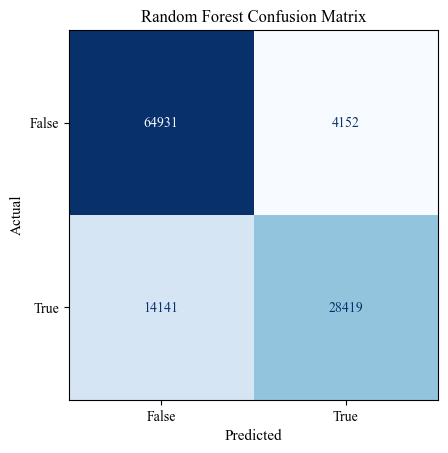

In [61]:
# Confussion matrix
# Compute the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['False', 'True'])

# Set the font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Plot the confusion matrix with a customized color map and additional styling
disp.plot(cmap='Blues', values_format='d', colorbar=False)

# Set the title and axis labels with customization
plt.title("Random Forest Confusion Matrix", fontsize=12)
plt.xlabel("Predicted", fontsize=11)
plt.ylabel("Actual", fontsize=11)

# Add gridlines for clarity
plt.grid(False)

##### Precision Recall Curve

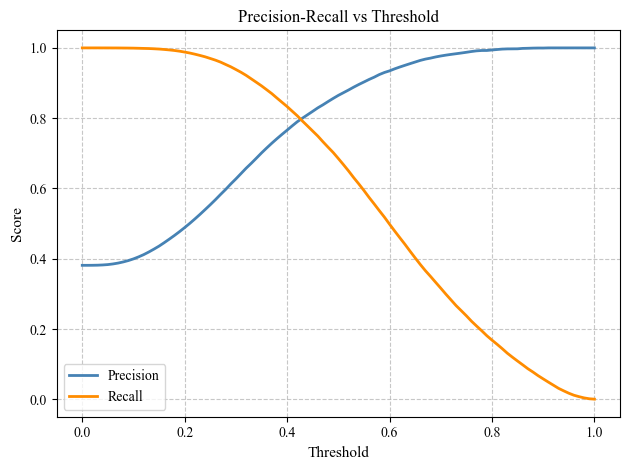

In [62]:
# Get predicted probabilities
y_scores = rf.predict_proba(X_val)[:, 1]

# Compute precision, recall, and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_val, y_scores)

# Set the font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Plot Precision and Recall with different line colors
plt.plot(thresholds, precisions[:-1], label='Precision', color='steelblue', linewidth=2)
plt.plot(thresholds, recalls[:-1], label='Recall', color='darkorange', linewidth=2)

# Add labels, title, and legend
plt.xlabel('Threshold', fontsize=11)
plt.ylabel('Score', fontsize=11)
plt.title('Precision-Recall vs Threshold', fontsize=12)
plt.legend()

# Show grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [63]:
# Print classification report
print("Classification Report:\n", classification_report(y_val, y_pred))

# Print ROC AUC score
print(f"ROC AUC Score: {roc_auc_score(y_val, y_pred):.4f}")

Classification Report:
               precision    recall  f1-score   support

       False       0.82      0.94      0.88     69083
        True       0.87      0.67      0.76     42560

    accuracy                           0.84    111643
   macro avg       0.85      0.80      0.82    111643
weighted avg       0.84      0.84      0.83    111643

ROC AUC Score: 0.8038


In [64]:
tn, fp, fn, tp = cm.ravel()

specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"Specificity (True Negative Rate): {specificity:.2f}")
print(f"Sensitivity (Recall / True Positive Rate): {sensitivity:.2f}")

Specificity (True Negative Rate): 0.94
Sensitivity (Recall / True Positive Rate): 0.67


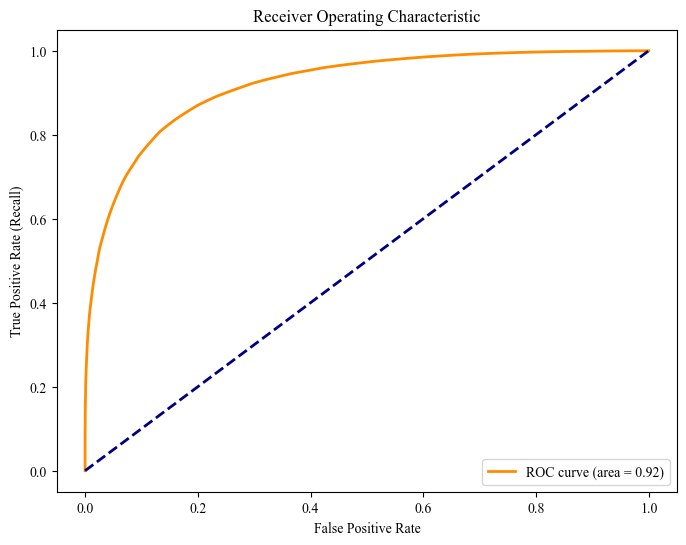

In [66]:
from sklearn.metrics import roc_curve, auc

# ROC and AUC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

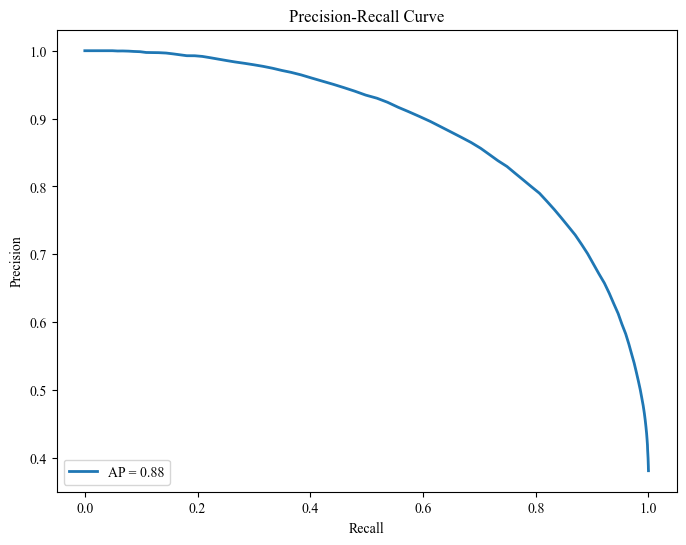

In [67]:
# Precision-Recall Curve

precision, recall, thresholds = precision_recall_curve(y_val, y_scores)
average_precision = average_precision_score(y_val, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, lw=2, label=f'AP = {average_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()